In [1]:
# Fine-Tuning GPT2-Large with QLoRA on Banking77 Dataset
# Purpose: Learning PEFT techniques for LLM fine-tuning

# ================================
# STEP 1: INSTALLATION AND IMPORTS
# ================================

# Install required packages for Google Colab
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers datasets accelerate bitsandbytes peft trl
!pip install scikit-learn matplotlib seaborn evaluate rouge-score

# Import necessary libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Transformers and PEFT
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")



Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.9/511.9 kB 41.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c5b28bf48ee1aa295241a624a6e9e0a830dbd2516ec2b28c626da844cba67fa4
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
Using device: cuda
GPU: Tesla T4
CUDA Version: 12.6


In [2]:
# ===============================
# STEP 2: DATASET PREPARATION
# ===============================

# Load Banking77 dataset
print("Loading Banking77 dataset...")
dataset = load_dataset("banking77")

# Explore the dataset
print(f"Dataset structure: {dataset}")
print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

# Show sample data
print("\nSample data:")
for i in range(3):
    print(f"Text: {dataset['train'][i]['text']}")
    print(f"Label: {dataset['train'][i]['label']}")
    print("---")

# Get label information
labels = dataset["train"].features["label"].names
num_labels = len(labels)
print(f"\nNumber of classes: {num_labels}")
print(f"Classes: {labels[:10]}...")  # Show first 10 classes

# Create a smaller subset for Colab free tier (optional - remove if you want full dataset)
train_size = 5000  # Adjust based on your memory constraints
test_size = 1000

train_dataset = (
    dataset["train"]
    .shuffle(seed=42)
    # .select(range(min(train_size, len(dataset["train"]))))
    .select(range(len(dataset["train"])))
)
test_dataset = (
    dataset["test"].shuffle(seed=42).select(range(min(test_size, len(dataset["test"]))))
)

print(
    f"Using {len(train_dataset)} training samples and {len(test_dataset)} test samples"
)

Loading Banking77 dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})
Train samples: 10003
Test samples: 3080

Sample data:
Text: I am still waiting on my card?
Label: 11
---
Text: What can I do if my card still hasn't arrived after 2 weeks?
Label: 11
---
Text: I have been waiting over a week. Is the card still coming?
Label: 11
---

Number of classes: 77
Classes: ['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire']...
Using 10003 training samples and 1000 test samples


In [3]:
# ===============================
# STEP 3: MODEL AND TOKENIZER SETUP
# ===============================

model_name = "openai-community/gpt2-large"
print(f"Loading model: {model_name}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add padding token (GPT2 doesn't have one by default)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# QLoRA Configuration for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# Load base model with quantization
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

# Configure model for classification
base_model.config.pad_token_id = tokenizer.pad_token_id

print("Model loaded successfully!")

Loading model: openai-community/gpt2-large


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!


In [4]:
# ===============================
# STEP 4: DATA PREPROCESSING
# ===============================


def preprocess_function(examples):
    """Tokenize the texts"""
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt",
    )


# Tokenize datasets
print("Tokenizing datasets...")
tokenized_train = train_dataset.map(
    preprocess_function, batched=True, remove_columns=["text"]
)
tokenized_test = test_dataset.map(
    preprocess_function, batched=True, remove_columns=["text"]
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Tokenizing datasets...


Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [5]:
# ===============================
# STEP 5: BASELINE EVALUATION
# ===============================

# Disable wandb completely
import os
os.environ["WANDB_DISABLED"] = "true"

def compute_metrics(eval_pred):
    """Compute classification metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# For baseline evaluation, we need to load the model without quantization
print("Loading non-quantized model for baseline evaluation...")
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
baseline_model.config.pad_token_id = tokenizer.pad_token_id

# Manual evaluation without Trainer to avoid wandb
print("Evaluating baseline model...")
baseline_model.eval()

all_predictions = []
all_labels = []

# Use DataLoader for proper batching
from torch.utils.data import DataLoader

# Create DataLoader
eval_dataloader = DataLoader(
    tokenized_test,
    batch_size=8,
    collate_fn=data_collator
)

with torch.no_grad():
    for batch in eval_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']

        # Get predictions
        outputs = baseline_model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics manually
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)

baseline_metrics = {
    'accuracy': accuracy,
    'f1': f1,
    'precision': precision,
    'recall': recall
}

print("Baseline Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Clean up baseline model to free memory
del baseline_model
torch.cuda.empty_cache()
print("Baseline evaluation completed and model cleaned up.")

Loading non-quantized model for baseline evaluation...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating baseline model...
Baseline Results:
Accuracy: 0.0080
F1: 0.0021
Precision: 0.0015
Recall: 0.0080
Baseline evaluation completed and model cleaned up.


In [6]:
# ===============================
# STEP 6: QLoRA CONFIGURATION
# ===============================

# LoRA configuration for QLoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=16,                    # Rank - you can experiment with 8, 16, 32, 64
    lora_alpha=32,           # LoRA scaling parameter
    lora_dropout=0.1,        # Dropout probability
    target_modules=["c_attn", "c_proj"],  # Target modules for GPT2
)

# Apply LoRA to the model
model = get_peft_model(base_model, lora_config)

# Print trainable parameters
model.print_trainable_parameters()

trainable params: 8,208,640 || all params: 782,337,280 || trainable%: 1.0492


In [7]:
# ===============================
# STEP 7: TRAINING CONFIGURATION
# ===============================

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,              # You can experiment with 1e-4, 2e-4, 5e-4
    per_device_train_batch_size=4,   # Adjust based on memory
    per_device_eval_batch_size=4,
    num_train_epochs=3,              # You can experiment with 2, 3, 5
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    push_to_hub=False,
    report_to=None,                  # Disable wandb for simplicity
    logging_steps=100,
    warmup_steps=100,
    fp16=False,
    bf16=True, # Mixed precision training
    dataloader_pin_memory=False,     # Helps with memory on Colab
    gradient_checkpointing=True,     # Saves memory
    remove_unused_columns=False,

)



Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [8]:
# ===============================
# STEP 8: TRAINING
# ===============================

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting QLoRA fine-tuning...")
start_time = datetime.now()

# Train the model
trainer.train()

end_time = datetime.now()
training_time = end_time - start_time
print(f"Training completed in: {training_time}")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Starting QLoRA fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,719.466200,804.270142,0.096000,0.086790,0.092721,0.096000
2,640.622400,800.480103,0.098000,0.089474,0.095280,0.098000
3,762.926200,800.197510,0.099000,0.090487,0.096208,0.099000


Training completed in: 0:45:08.126493


In [9]:
# ===============================
# STEP 9: EVALUATION
# ===============================

print("Evaluating fine-tuned model...")
eval_results = trainer.evaluate()

print("\nFine-tuned Model Results:")
for key, value in eval_results.items():
    if key.startswith('eval_'):
        print(f"{key}: {value:.4f}")

# Store fine-tuned results
finetuned_metrics = {
    'accuracy': eval_results['eval_accuracy'],
    'f1': eval_results['eval_f1'],
    'precision': eval_results['eval_precision'],
    'recall': eval_results['eval_recall']
}

Evaluating fine-tuned model...



Fine-tuned Model Results:
eval_loss: 800.1975
eval_accuracy: 0.0990
eval_f1: 0.0905
eval_precision: 0.0962
eval_recall: 0.0990
eval_runtime: 71.6121
eval_samples_per_second: 13.9640
eval_steps_per_second: 3.4910


In [10]:
# ===============================
# STEP 10: RESULTS COMPARISON
# ===============================

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Baseline (GPT2-Large)', 'QLoRA Fine-tuned'],
    'Accuracy': [baseline_metrics['accuracy'], finetuned_metrics['accuracy']],
    'F1 Score': [baseline_metrics['f1'], finetuned_metrics['f1']],
    'Precision': [baseline_metrics['precision'], finetuned_metrics['precision']],
    'Recall': [baseline_metrics['recall'], finetuned_metrics['recall']]
})

print("\n" + "="*50)
print("RESULTS COMPARISON")
print("="*50)
print(comparison_df.round(4))

# Calculate improvements
improvements = {
    'accuracy': ((finetuned_metrics['accuracy'] - baseline_metrics['accuracy']) / baseline_metrics['accuracy']) * 100,
    'f1': ((finetuned_metrics['f1'] - baseline_metrics['f1']) / baseline_metrics['f1']) * 100,
    'precision': ((finetuned_metrics['precision'] - baseline_metrics['precision']) / baseline_metrics['precision']) * 100,
    'recall': ((finetuned_metrics['recall'] - baseline_metrics['recall']) / baseline_metrics['recall']) * 100
}

print("\nPerformance Improvements:")
for metric, improvement in improvements.items():
    print(f"{metric.capitalize()}: {improvement:+.2f}%")


RESULTS COMPARISON
                   Model  Accuracy  F1 Score  Precision  Recall
0  Baseline (GPT2-Large)     0.008    0.0021     0.0015   0.008
1       QLoRA Fine-tuned     0.099    0.0905     0.0962   0.099

Performance Improvements:
Accuracy: +1137.50%
F1: +4146.02%
Precision: +6354.76%
Recall: +1137.50%


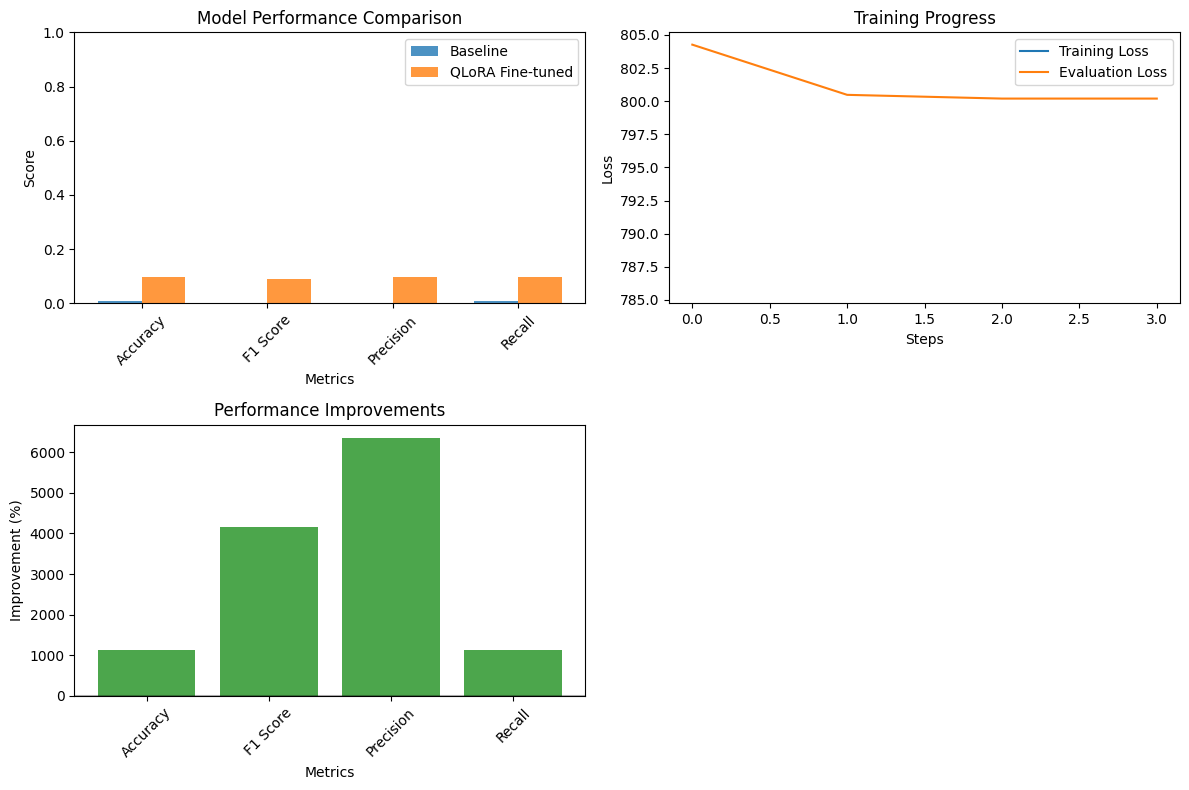

In [11]:
# ===============================
# STEP 11: VISUALIZATIONS
# ===============================

# Create visualization
plt.figure(figsize=(12, 8))

# Bar plot comparison
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
baseline_values = [baseline_metrics['accuracy'], baseline_metrics['f1'],
                  baseline_metrics['precision'], baseline_metrics['recall']]
finetuned_values = [finetuned_metrics['accuracy'], finetuned_metrics['f1'],
                   finetuned_metrics['precision'], finetuned_metrics['recall']]

x = np.arange(len(metrics))
width = 0.35

plt.subplot(2, 2, 1)
plt.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8)
plt.bar(x + width/2, finetuned_values, width, label='QLoRA Fine-tuned', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.ylim(0, 1)

# Training loss plot (if available)
if hasattr(trainer.state, 'log_history'):
    plt.subplot(2, 2, 2)
    log_history = trainer.state.log_history
    train_loss = [log['train_loss'] for log in log_history if 'train_loss' in log]
    eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

    if train_loss:
        plt.plot(train_loss, label='Training Loss')
    if eval_loss:
        plt.plot(eval_loss, label='Evaluation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()

# Improvement percentages
plt.subplot(2, 2, 3)
improvement_values = list(improvements.values())
colors = ['green' if x > 0 else 'red' for x in improvement_values]
plt.bar(metrics, improvement_values, color=colors, alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Improvement (%)')
plt.title('Performance Improvements')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# # ===============================
# # STEP 12: DETAILED ANALYSIS
# # ===============================

# # Get predictions for detailed analysis
# predictions = trainer.predict(tokenized_test)
# y_pred = np.argmax(predictions.predictions, axis=1)
# y_true = predictions.label_ids

# # Classification report
# print("\nDetailed Classification Report:")
# print(classification_report(y_true, y_pred, target_names=[labels[i] for i in sorted(set(y_true))]))

# ===============================
# STEP 12: DETAILED ANALYSIS
# ===============================

# Get predictions for detailed analysis
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Load full label names directly from dataset to avoid mismatches
from datasets import load_dataset
dataset = load_dataset("banking77")
labels = dataset["train"].features["label"].names

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=sorted(set(y_true)),                # ensure alignment
    target_names=[labels[i] for i in sorted(set(y_true))]
))



Detailed Classification Report:
                                                  precision    recall  f1-score   support

                                activate_my_card       0.00      0.00      0.00        16
                                       age_limit       0.50      0.38      0.43        16
                         apple_pay_or_google_pay       0.21      0.15      0.18        20
                                     atm_support       0.19      0.45      0.26        11
                                automatic_top_up       0.00      0.00      0.00        10
         balance_not_updated_after_bank_transfer       0.04      0.09      0.05        11
balance_not_updated_after_cheque_or_cash_deposit       0.00      0.00      0.00        19
                         beneficiary_not_allowed       0.00      0.00      0.00        15
                                 cancel_transfer       0.00      0.00      0.00        13
                            card_about_to_expire       0.08      0

In [15]:
# ===============================
# STEP 13: MODEL INFORMATION
# ===============================

print("\n" + "="*50)
print("MODEL CONFIGURATION")
print("="*50)
print(f"Base Model: {model_name}")
print(f"Fine-tuning Method: QLoRA")
print(f"Dataset: Banking77")
print(f"Training Samples: {len(train_dataset)}")
print(f"Test Samples: {len(test_dataset)}")
print(f"Number of Classes: {num_labels}")
print(f"Training Time: {training_time}")

print("\nLoRA Configuration:")
print(f"Rank (r): {lora_config.r}")
print(f"Alpha: {lora_config.lora_alpha}")
print(f"Dropout: {lora_config.lora_dropout}")
print(f"Target Modules: {lora_config.target_modules}")

print("\nTraining Configuration:")
print(f"Learning Rate: {training_args.learning_rate}")
print(f"Batch Size: {training_args.per_device_train_batch_size}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Weight Decay: {training_args.weight_decay}")


MODEL CONFIGURATION
Base Model: openai-community/gpt2-large
Fine-tuning Method: QLoRA
Dataset: Banking77
Training Samples: 10003
Test Samples: 1000
Number of Classes: 77
Training Time: 0:45:08.126493

LoRA Configuration:
Rank (r): 16
Alpha: 32
Dropout: 0.1
Target Modules: {'c_attn', 'c_proj'}

Training Configuration:
Learning Rate: 0.0002
Batch Size: 4
Epochs: 3
Weight Decay: 0.01


In [16]:
# ===============================
# STEP 14: SAVE RESULTS
# ===============================

# Save the fine-tuned model
model.save_pretrained("./gpt2-large-banking77-qlora")
tokenizer.save_pretrained("./gpt2-large-banking77-qlora")

print("\nModel saved to './gpt2-large-banking77-qlora'")

# Create results summary
results_summary = {
    'experiment_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'model': model_name,
    'method': 'QLoRA',
    'dataset': 'Banking77',
    'baseline_metrics': baseline_metrics,
    'finetuned_metrics': finetuned_metrics,
    'improvements': improvements,
    'training_time': str(training_time),
    'lora_config': {
        'r': lora_config.r,
        'alpha': lora_config.lora_alpha,
        'dropout': lora_config.lora_dropout,
    },
    'training_config': {
        'learning_rate': training_args.learning_rate,
        'batch_size': training_args.per_device_train_batch_size,
        'epochs': training_args.num_train_epochs,
    }
}

# Save results to file
import json
with open('experiment_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to 'experiment_results.json'")


Model saved to './gpt2-large-banking77-qlora'
Results saved to 'experiment_results.json'


In [17]:
# ===============================
# STEP 15: FINAL SUMMARY
# ===============================

print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)
print(f"✅ Successfully fine-tuned {model_name} using QLoRA")
print(f"✅ Dataset: Banking77 (Intent Classification)")
print(f"✅ Training completed in: {training_time}")
print("\nKey Results:")
print(f"📈 Accuracy improved by {improvements['accuracy']:+.2f}%")
print(f"📈 F1 Score improved by {improvements['f1']:+.2f}%")
print(f"📊 Final Accuracy: {finetuned_metrics['accuracy']:.4f}")
print(f"📊 Final F1 Score: {finetuned_metrics['f1']:.4f}")

print(f"\n🔧 LoRA Parameters: r={lora_config.r}, α={lora_config.lora_alpha}")
print(f"🎯 Training Parameters: lr={training_args.learning_rate}, epochs={training_args.num_train_epochs}")

print("\n💾 Files saved:")
print("- Model: './gpt2-large-banking77-qlora'")
print("- Results: 'experiment_results.json'")

print("\n🎉 Experiment completed successfully!")


EXPERIMENT SUMMARY
✅ Successfully fine-tuned openai-community/gpt2-large using QLoRA
✅ Dataset: Banking77 (Intent Classification)
✅ Training completed in: 0:45:08.126493

Key Results:
📈 Accuracy improved by +1137.50%
📈 F1 Score improved by +4146.02%
📊 Final Accuracy: 0.0990
📊 Final F1 Score: 0.0905

🔧 LoRA Parameters: r=16, α=32
🎯 Training Parameters: lr=0.0002, epochs=3

💾 Files saved:
- Model: './gpt2-large-banking77-qlora'
- Results: 'experiment_results.json'

🎉 Experiment completed successfully!
